In [1]:
import numpy as np
import h5py

from src import io, corr
import matplotlib.pyplot as plt
from matplotlib import colors

In [2]:
exp_date = '251014'
exp_num = '1701'

experiment_path = io.get_experiment(exp_date, exp_num)
supervox_path = io.get_file(experiment_path, 'processed', '*supervoxels.h5')
labels_path = io.get_file(experiment_path, 'processed', '*labels.h5')
print(supervox_path, labels_path)

# open h5 and pull data
with h5py.File(labels_path, 'r') as labels_hf:
    cluster_labels = labels_hf['labels'][...]

with h5py.File(supervox_path,'r') as supervox_hf:
    ca_signal = supervox_hf['ca_signal'][...]
    fictrac_sp = supervox_hf['smoothed_speed'][...]
    fictrac_t = supervox_hf['fictrac_time'][...]
    camera_fr = supervox_hf['camera_fr'][...]
    scope_fr = supervox_hf['scope_fr'][...]
    brain_dim = supervox_hf['brain_dimensions'][...]

# maui time conversions
frames = [x for x in range(1, ca_signal.shape[-1])]
volume_per_s = scope_fr/ca_signal.shape[0] # volume rate in Hz
maui_time = [0] + [x / volume_per_s for x in frames]

brain_dim= brain_dim.reshape(-1)
# fictrac time conversions
fic_time = fictrac_t / camera_fr

/home/ptarabishi/repos/ROI_analysis/251014_1701/processed/251014_1701_supervoxels.h5 /home/ptarabishi/repos/ROI_analysis/251014_1701/processed/251014_1701_labels.h5


In [3]:
print(ca_signal.shape)
fictrac_resample = corr.downsize_dataset(fictrac_sp, ca_signal)

pearson_arr = corr.pearson_analysis(ca_signal, fictrac_resample)
sorted_pearson = corr.sort_descending(pearson_arr)
print(len(pearson_arr))  # [slices, pearson coefficient of each roi]

(31, 500, 978)
978 978
15500


In [4]:
cluster_n = ca_signal.shape[1] # number of rois found in each slice
new_cluster_labels = []
for slice_idx, clusters in enumerate(cluster_labels):
    add_to = cluster_n * slice_idx
    # print(add_to)
    new_cluster_labels.append(clusters+add_to)

# reshape list to np.array
new_cluster_labels= np.reshape(new_cluster_labels, (ca_signal.shape[0],brain_dim[0], brain_dim[1]))
print(new_cluster_labels.shape)

pearson_arr_reshape = pearson_arr.reshape(ca_signal.shape[0], -1)
print(pearson_arr_reshape.shape)

(31, 256, 256)
(31, 500)


In [5]:
# use roi index to fill in pearson coefficient at each pixel
corr_array = []
for slice_idx, clusters in enumerate(cluster_labels):
    # for each slice initialize an array
    # for each v
    for id in cluster_labels[slice_idx]:
        corr_value = pearson_arr_reshape[slice_idx, id]
        # print(id, corr_value)
        # np.append(corr_array, corr_value)
        corr_array.append(corr_value)
corr_array = np.array(corr_array).reshape(ca_signal.shape[0],brain_dim[0], brain_dim[1])
print(corr_array.shape)

(31, 256, 256)


32


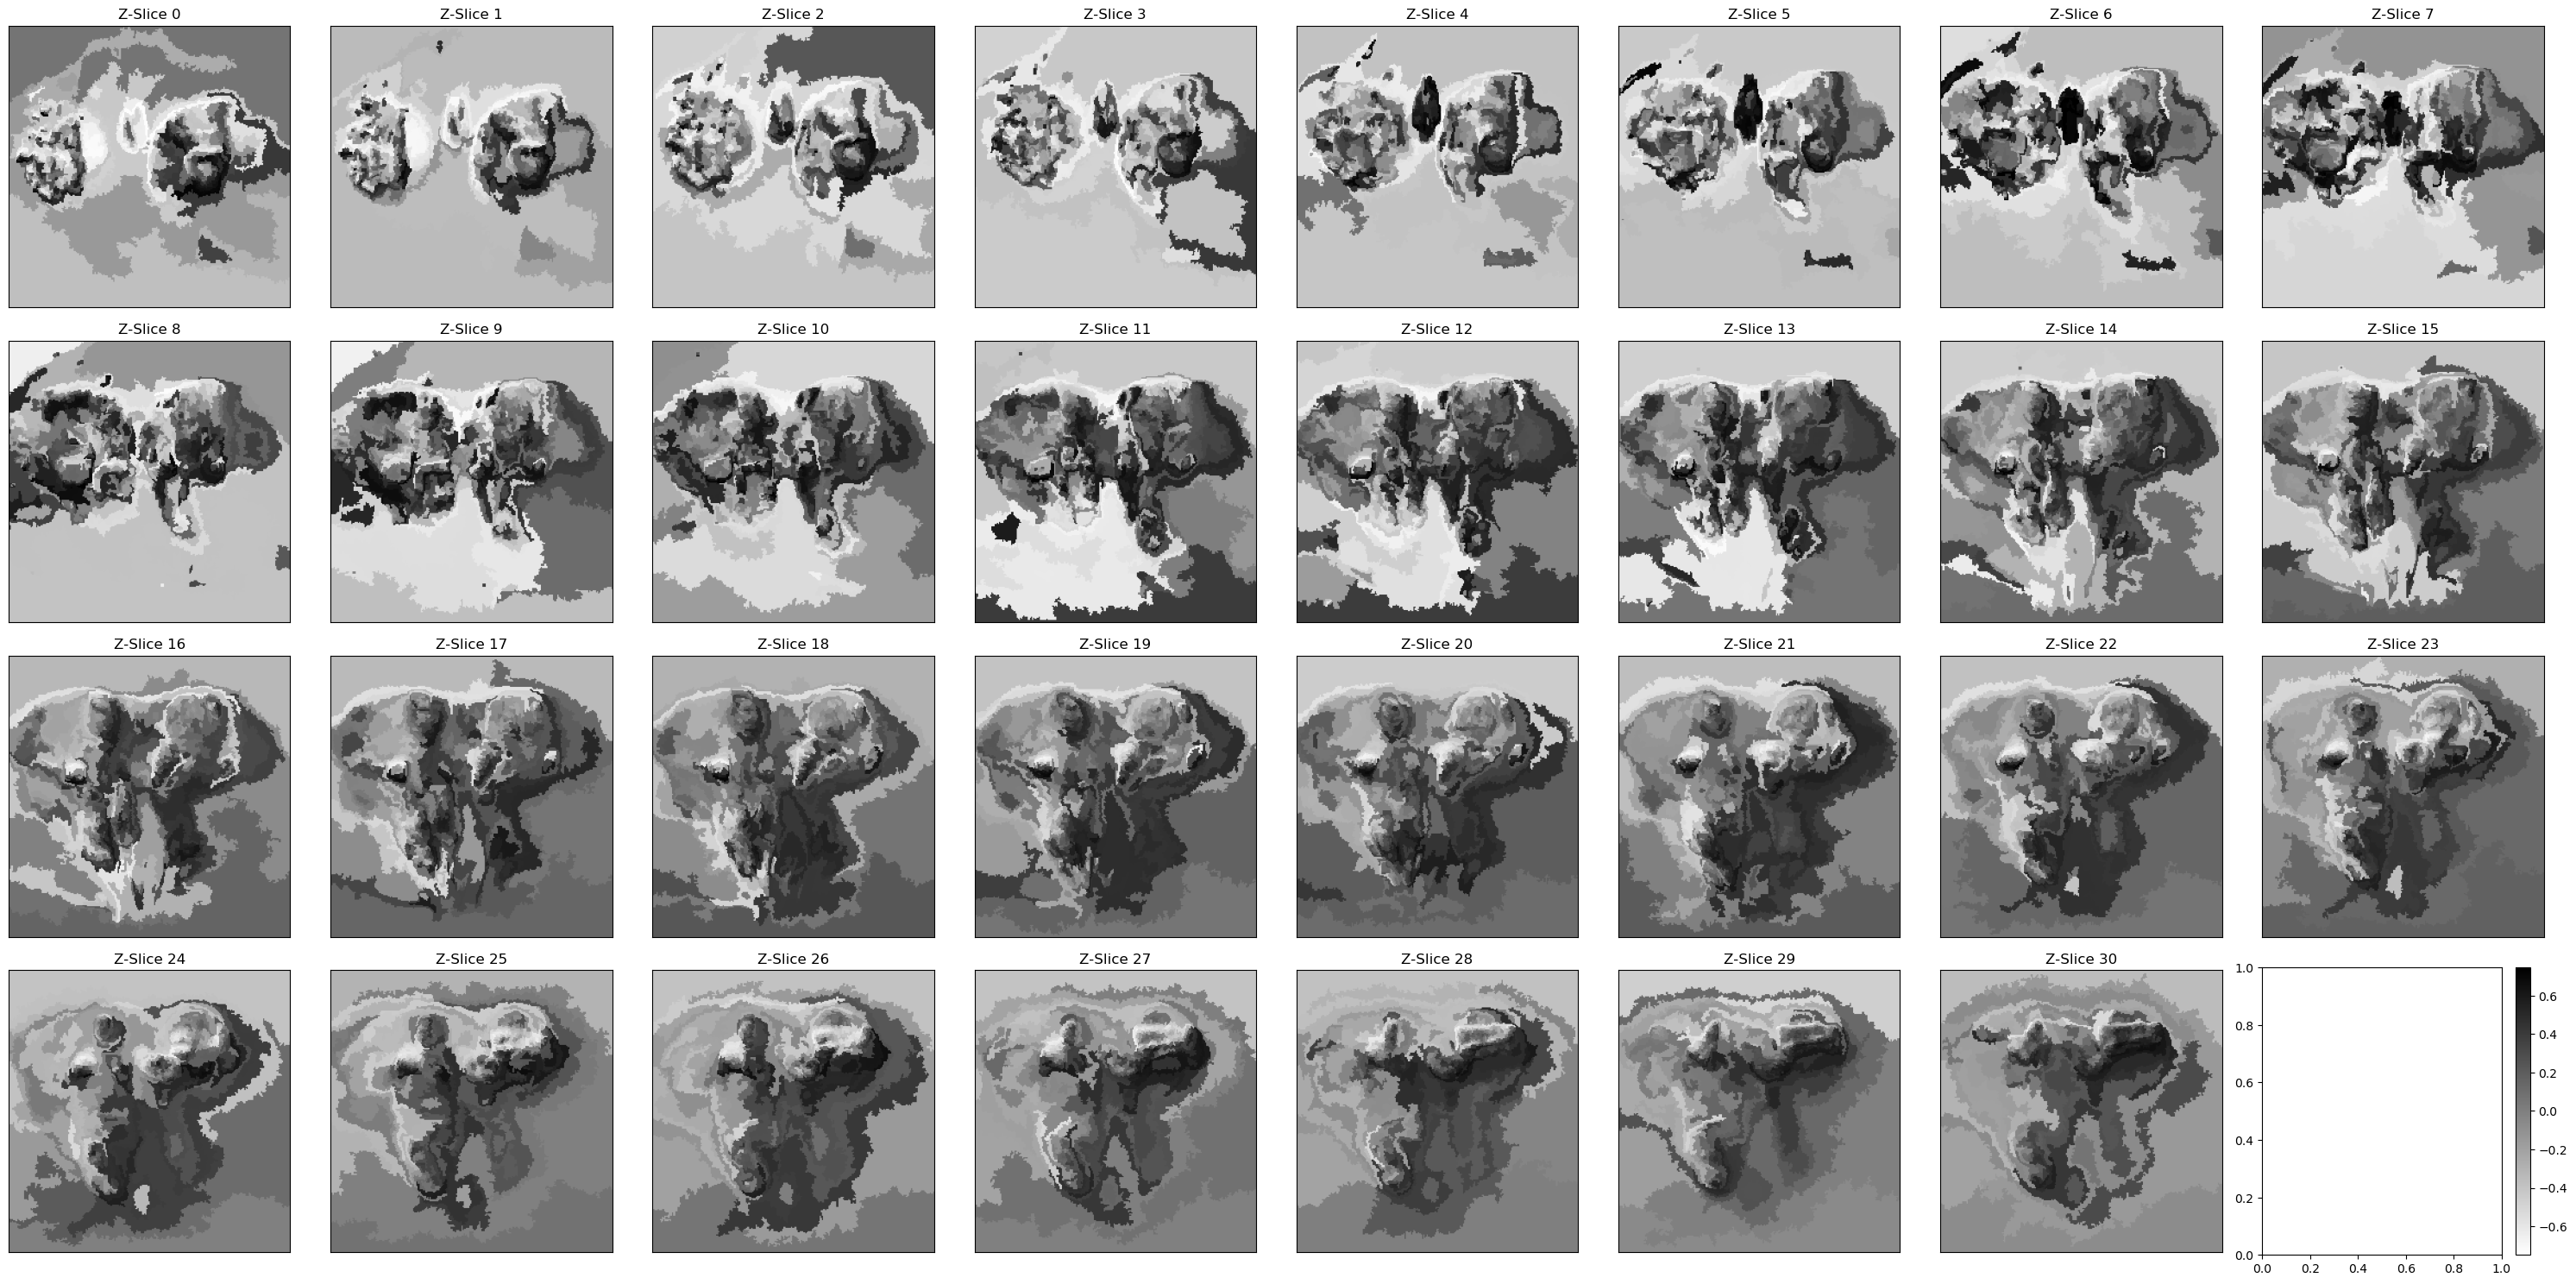

In [6]:
fig, axes = plt.subplots(4, 8, figsize=(30, 15)) # (xaxis, yaxis, figure size)
cmap = 'gray_r'
# Flatten the 2D array of axes for easier iteration
axes = axes.flatten()
print(len(axes))
# create a single norm to be shared across all images
norm_all = colors.Normalize(vmin=np.min(corr_array), vmax=np.max(corr_array))
images = []
# Populate each subplot with some sample data
for i, ax in enumerate(axes):
    if i < corr_array.shape[0]:
        images.append(ax.imshow(corr_array[i].T, cmap=cmap, norm=norm_all))
        ax.set_title(f'Z-Slice {i}')
        ax.set_xticks([]) # Hide x-axis ticks for cleaner appearance
        ax.set_yticks([]) # Hide
fig.colorbar(images[0], ax=ax, orientation='vertical', fraction=.1)
plt.tight_layout()
plt.show()

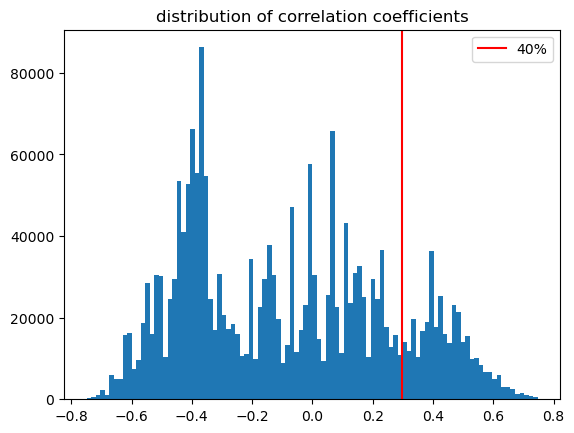

In [7]:
percent = 40
threshold = np.max(corr_array)*(percent/100)
plt.hist(corr_array.reshape(-1), bins=100)
plt.axvline(threshold, color='r', label = fr'{percent}%')
plt.title('distribution of correlation coefficients')
plt.legend()
plt.show()

(31, 65536)
32


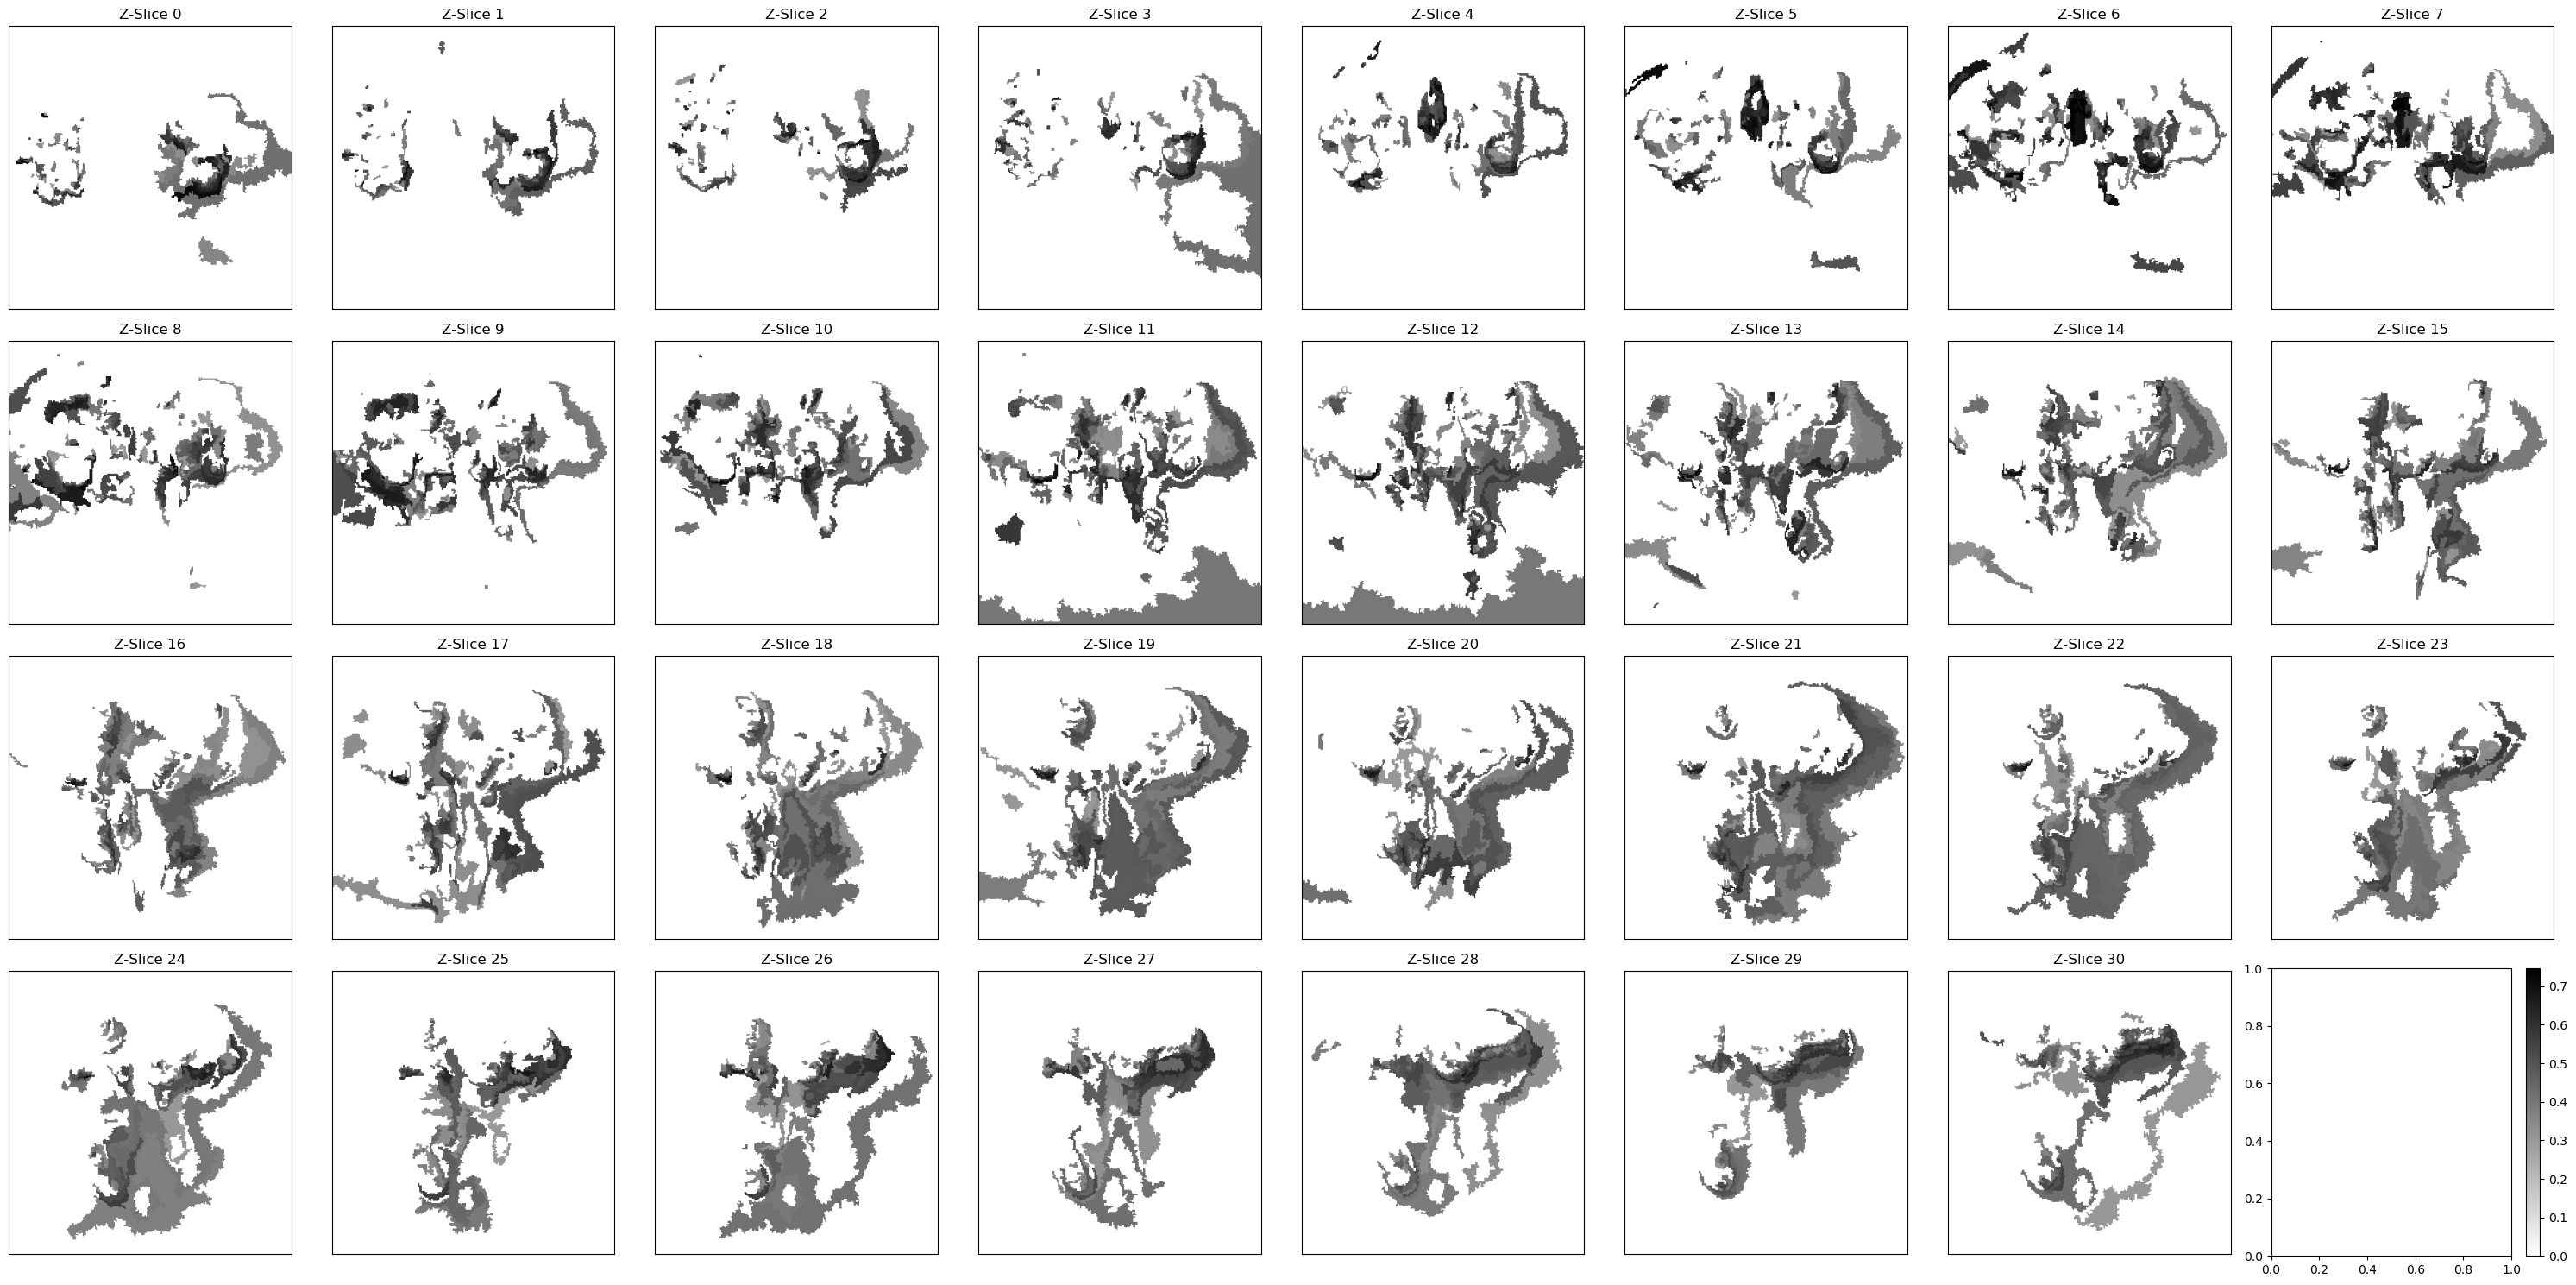

In [8]:
# to plot the spatial organization of rois with high correlation
highly_corr = []
corr_array_simple = corr_array.reshape(ca_signal.shape[0],-1)
print(corr_array_simple.shape)
for slice_idx, clusters in enumerate(corr_array_simple):
    for value in corr_array_simple[slice_idx]:
        if value > threshold:
            highly_corr.append(value)
        else:
            highly_corr.append(0)

toplot_2 = np.array(highly_corr).reshape(ca_signal.shape[0],brain_dim[0], brain_dim[1])

fig, axes = plt.subplots(4, 8, figsize=(30, 15)) # (xaxis, yaxis, figure size)
cmap = 'gray_r'
# Flatten the 2D array of axes for easier iteration
axes = axes.flatten()
print(len(axes))
# create a single norm to be shared across all images
norm = colors.Normalize(vmin=np.min(toplot_2), vmax=np.max(toplot_2))
images = []
# Populate each subplot with some sample data
for i, ax in enumerate(axes):
    if i < toplot_2.shape[0]:
        images.append(ax.imshow(toplot_2[i].T, cmap=cmap, norm=norm))
        ax.set_title(f'Z-Slice {i}')
        ax.set_xticks([]) # Hide x-axis ticks for cleaner appearance
        ax.set_yticks([]) # Hide
fig.colorbar(images[0], ax=ax, orientation='vertical', fraction=.1)

plt.tight_layout()
plt.show()

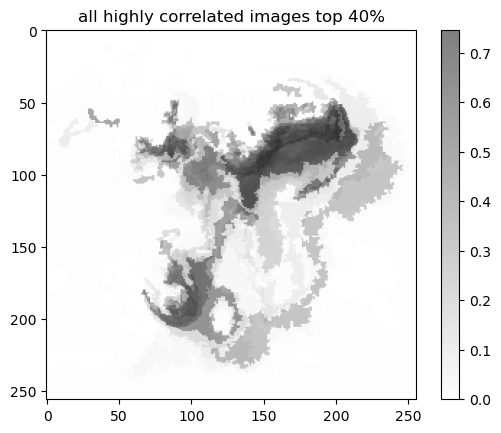

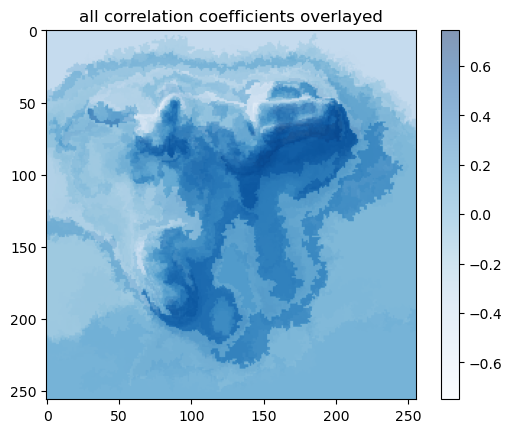

In [10]:
plt.figure()
for slice, a in enumerate(toplot_2):
    plt.imshow(toplot_2[slice].T, cmap=cmap, norm=norm, alpha=.5)
plt.colorbar()
plt.title(fr'all highly correlated images top {percent}%')
plt.show()

plt.figure()
for slice, a in enumerate(corr_array):
    plt.imshow(corr_array[slice].T, cmap='Blues', norm=norm_all, alpha=.5)
plt.colorbar()
plt.title('all correlation coefficients overlayed')
plt.show()

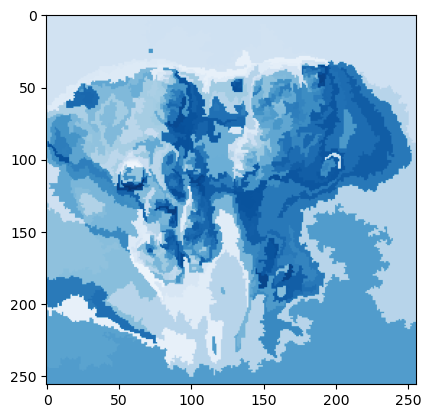

In [11]:
plt.imshow(corr_array[14].T, cmap='Blues', norm=norm_all)